In [58]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [59]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


In [60]:
# Load data
df = pd.read_csv('/content/detailed_ev_charging_stations.csv')

In [61]:
def preprocess_ev_data(df):
    # 1. Extract City from Address (assuming standard comma-separated format)
    df['City'] = df['Address'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else 'Unknown')

    # 2. Convert Availability to Operating Hours
    # Mapping text descriptions to total daily hours
    availability_map = {'24/7': 24, '9:00-18:00': 9, '6:00-22:00': 16}
    df['Daily_Hours'] = df['Availability'].map(availability_map)

    # 3. Clean numeric columns
    df['Cost (USD/kWh)'] = pd.to_numeric(df['Cost (USD/kWh)'], errors='coerce')

    # Ensure numerical types
    df['Installation Year'] = df['Installation Year'].astype(int)
    return df

df_cleaned = preprocess_ev_data(df)

In [62]:
df.head()

,Station ID,Latitude,Longitude,Address,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage Stats (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency,City,Daily_Hours
0,EVS00001,-33.400998,77.974972,"4826 Random Rd, City 98, Country",AC Level 2,0.27,9:00-18:00,4.95,35,EVgo,350,"CCS, CHAdeMO",2013,Yes,4.0,7,Annually,Country,9
1,EVS00002,37.861857,-122.490299,"8970 San Francisco Ave, San Francisco",DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly,San Francisco,24
2,EVS00003,13.776092,100.412776,"5974 Bangkok Ave, Bangkok",AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually,Bangkok,16
3,EVS00004,43.628250,-79.468935,"6995 Toronto Ave, Toronto",AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly,Toronto,9
4,EVS00005,19.119865,72.913368,"5704 Mumbai Ave, Mumbai",AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually,Mumbai,9


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Station ID                   5000 non-null   object 
 1   Latitude                     5000 non-null   float64
 2   Longitude                    5000 non-null   float64
 3   Address                      5000 non-null   object 
 4   Charger Type                 5000 non-null   object 
 5   Cost (USD/kWh)               5000 non-null   float64
 6   Availability                 5000 non-null   object 
 7   Distance to City (km)        5000 non-null   float64
 8   Usage Stats (avg users/day)  5000 non-null   int64  
 9   Station Operator             5000 non-null   object 
 10  Charging Capacity (kW)       5000 non-null   int64  
 11  Connector Types              5000 non-null   object 
 12  Installation Year            5000 non-null   int64  
 13  Renewable Energy S

In [64]:
def calculate_kpis(df):
    # Assume an average charge of 30 kWh per user session
    kwh_per_user = 30

    # Calculate Revenue
    df['Est_Daily_Revenue'] = df['Usage Stats (avg users/day)'] * kwh_per_user * df['Cost (USD/kWh)']

    # Calculate Utilization (assuming 100 users/day is 100% capacity)
    df['Utilization_Rate'] = (df['Usage Stats (avg users/day)'] / 100) * 100

    return df

df_final = calculate_kpis(df_cleaned)

In [65]:
charger_counts = df['Charger Type'].value_counts()


(np.float64(-1.1481424762532477),
 np.float64(1.1022922003242865),
 np.float64(-1.1195063218594308),
 np.float64(1.100927938599118))

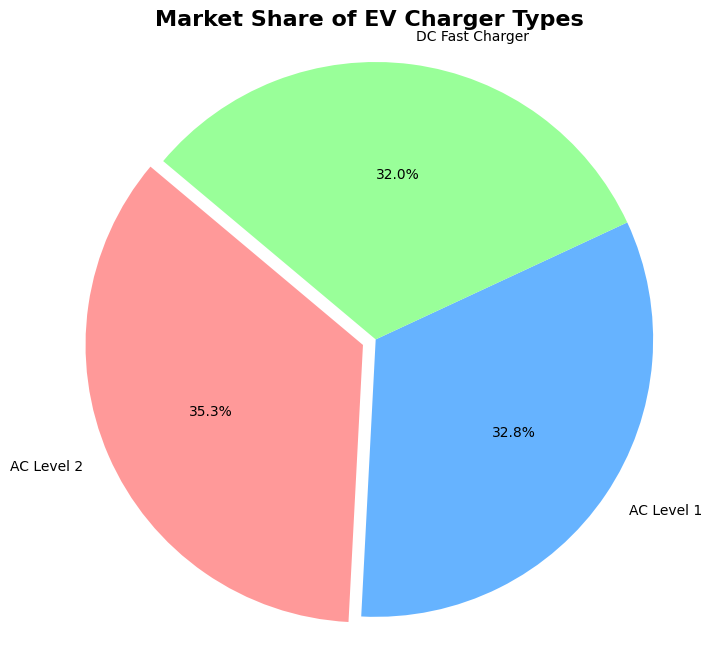

In [66]:
plt.figure(figsize=(8, 8))
colors = ['#ff9999','#66b3ff','#99ff99'] # Soft red, blue, and green
plt.pie(charger_counts,
        labels=charger_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=(0.05, 0, 0))
plt.title('Market Share of EV Charger Types', fontsize=16, fontweight='bold')
plt.axis('equal')

In [67]:
connector_series = df['Connector Types'].str.split(',').explode().str.strip()
connector_counts = connector_series.value_counts()

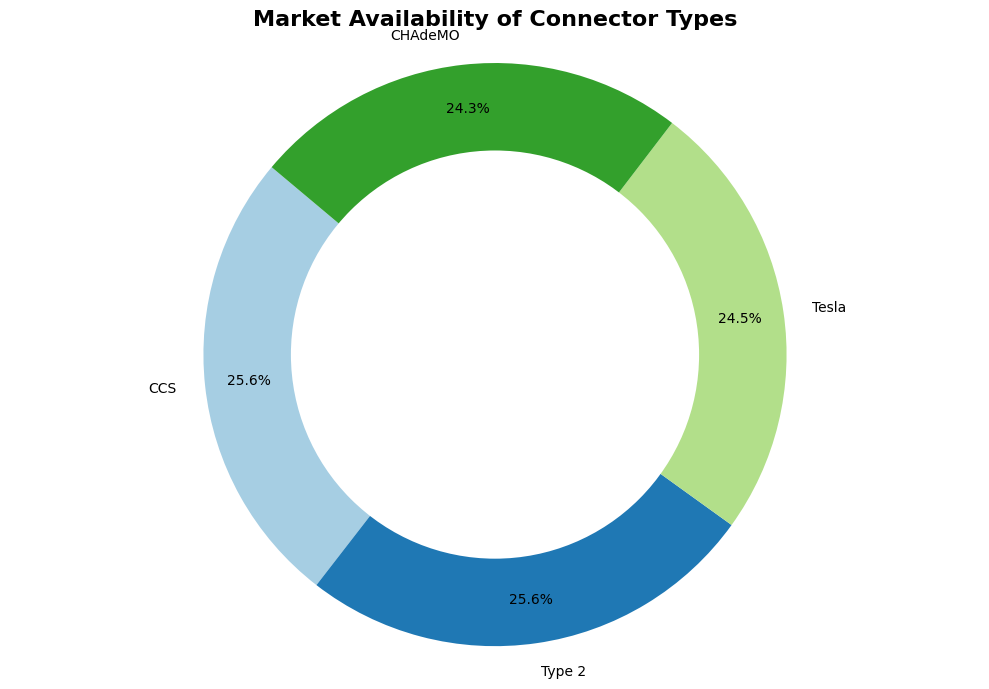

In [68]:
plt.figure(figsize=(10, 7))
colors = plt.cm.Paired(range(len(connector_counts)))

plt.pie(connector_counts,
        labels=connector_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        pctdistance=0.85)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Market Availability of Connector Types', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()

In [69]:
operator_counts = df['Station Operator'].value_counts().reset_index()
operator_counts.columns = ['Station Operator', 'Count']

/tmp/ipython-input-44786400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=operator_counts, x='Station Operator', y='Count', palette='viridis')


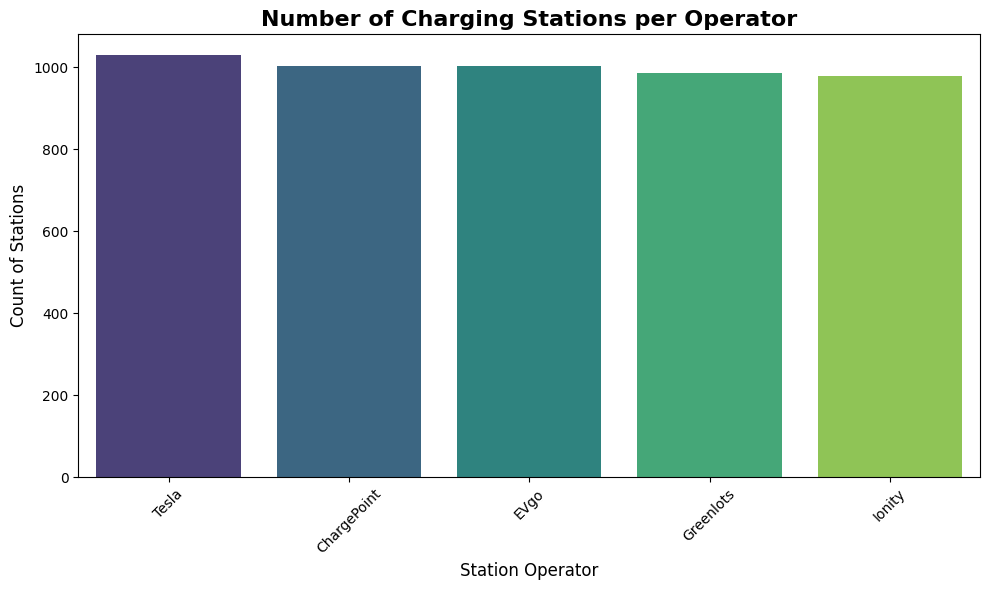

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(data=operator_counts, x='Station Operator', y='Count', palette='viridis')
plt.title('Number of Charging Stations per Operator', fontsize=16, fontweight='bold')
plt.xlabel('Station Operator', fontsize=12)
plt.ylabel('Count of Stations', fontsize=12)
plt.xticks(rotation=45) # Rotates labels for better readability
plt.tight_layout()

In [71]:
!pip install mysql-connector-python

In [72]:
import mysql.connector

In [73]:
def export_to_mysql(df):
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="verma495450",
        database="detailed_ev_charging_stations"
    )

    cursor = conn.cursor()

    # Create table manually (MySQL requires schema)
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS charging_stations (
        `Station Operator` VARCHAR(255),
        Daily_Revenue_Est FLOAT
    )
    """)

    # Insert data
    for _, row in df.iterrows():
        cursor.execute("""
        INSERT INTO charging_stations (`Station Operator`, Daily_Revenue_Est)
        VALUES (%s, %s)
        """, (row["Station Operator"], row["Daily_Revenue_Est"]))

    conn.commit()

    # Query
    query = """
    SELECT `Station Operator`, SUM(Daily_Revenue_Est) as Total_Revenue
    FROM charging_stations
    GROUP BY `Station Operator`
    ORDER BY Total_Revenue DESC
    LIMIT 5
    """

    cursor.execute(query)
    result = cursor.fetchall()

    print("\n--- SQL Query Result: Top Operators ---")
    for row in result:
        print(row)

    conn.close()


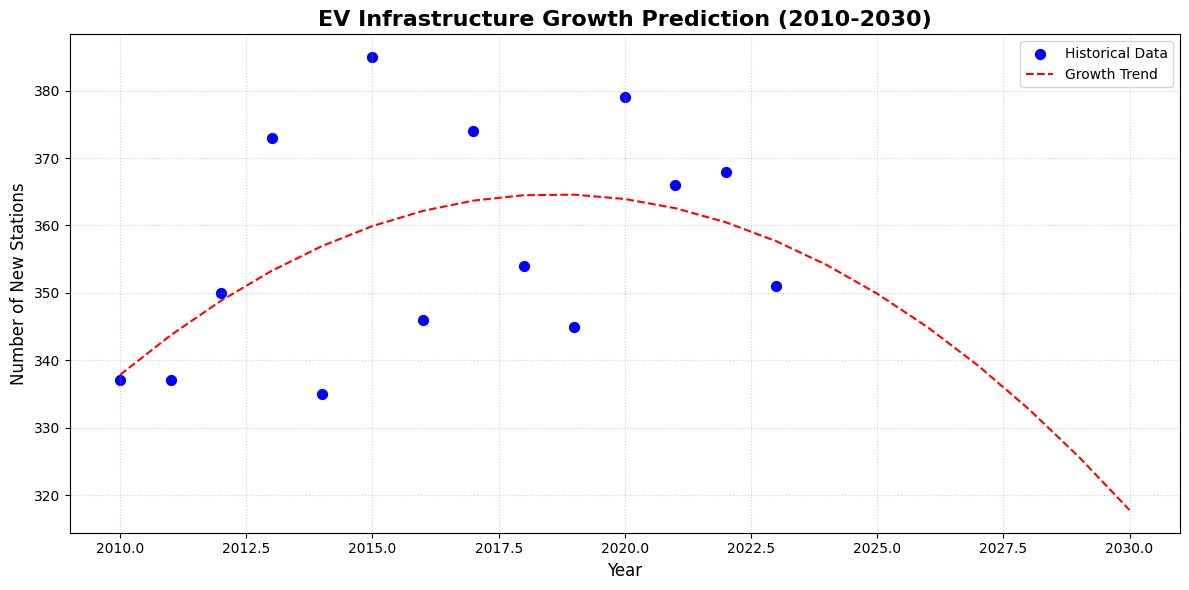

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



# 1. Prepare historical installation data
growth_data = df.groupby('Installation Year').size().reset_index(name='New_Stations')
X = growth_data[['Installation Year']].values
y = growth_data['New_Stations'].values

# 2. Fit Polynomial Regression (Degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)

# 3. Forecast for 2024 - 2030
future_years = np.array(range(2024, 2031)).reshape(-1, 1)
all_years = np.append(X, future_years).reshape(-1, 1)

# 4. Plotting (Completed from your snippet)
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', label='Historical Data', s=50)
plt.plot(all_years,
         model.predict(poly.transform(all_years)),
         color='red', linestyle='--', label='Growth Trend')

plt.title("EV Infrastructure Growth Prediction (2010-2030)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of New Stations", fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

